In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import r2_score
pd.options.display.float_format = '{:.2f}'.format

#データの読み込み
df = pd.read_csv("./datasets/ks-projects-201801.csv", sep=',',parse_dates=['deadline', 'launched'])

# 目的変数を算出
df['achievement_rate'] = df['usd_pledged_real']*100/df['usd_goal_real']
# achievement_rateが10以下の場合0、それ以外の場合1
df['achievement_type'] = df['achievement_rate'].apply(lambda x : 0 if x < 90 else 1)

# 必要のないデータをドロップ
df = df.drop(['pledged','usd pledged','usd_pledged_real','goal','backers','state','name'], axis=1)

# 異常値除外
df = df[df['achievement_rate']<200]

# 全データのうち、20%をテストデータにする
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234) 

# main_category
grouped_main_category = df_train.groupby('main_category')
Statistics_main_category = grouped_main_category.describe()['achievement_rate']

# category
grouped_category = df_train.groupby('category')
Statistics_category = grouped_category.describe()['achievement_rate']

#currency
grouped_currency = df_train.groupby('currency')
Statistics_currency = grouped_currency.describe()['achievement_rate']

#country
grouped_country = df_train.groupby('country')
Statistics_country = grouped_country.describe()['achievement_rate']

# 基礎統計情報を結合
df_merged_train  = pd.merge(df_train,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_train  = pd.merge(df_merged_train,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])

df_merged_test  = pd.merge(df_test,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_test  = pd.merge(df_merged_test,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])


# dropするカラム
drop_columns = ['ID','deadline','launched'
                                    ,'min','max','count','50%','75%'
                                    ,'min_category','max_category' ,'count_category','50%_category','75%_category'
                                    ,'min_currency','max_currency' ,'count_currency','50%_currency','75%_currency'
                                    ,'min_country','max_country' ,'count_country','50%_country','75%_country']
df_merged_train = df_merged_train.drop(drop_columns, axis=1)
df_merged_test = df_merged_test.drop(drop_columns, axis=1)

# main_category、category、countryはダミー変数を取得する。
df_merged_train = pd.get_dummies(df_merged_train, drop_first=True)
df_merged_test = pd.get_dummies(df_merged_test, drop_first=True)

# 欠損値を除外する。
df_merged_train = df_merged_train.dropna()
df_merged_test = df_merged_test.dropna()

X_train = df_merged_train.drop(['achievement_type','achievement_rate'], axis=1).values
y_train = df_merged_train['achievement_type'].values
X_test = df_merged_test.drop(['achievement_type','achievement_rate'], axis=1).values
y_test = df_merged_test['achievement_type'].values


## 1. RandomForestとAdaBoostを用いて、資金調達率が10%未満とそれ以上を分類する

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [3]:
# ランダムフォレストのグリッドサーチ
search_params = {
     'n_estimators'      : [5, 10, 20, 30],
      'max_features'      : [3, 5, 10, 15],
      'random_state'      : [1234],
      'n_jobs'            : [1],
      'min_samples_split' : [3, 5, 10, 15],
      'max_depth'         : [3, 5, 10, 15]
}

gs = GridSearchCV(RandomForestClassifier(),    # 対象の機械学習モデル
                  search_params,   # 探索パラメタ辞書
                  cv=3,                    # クロスバリデーションの分割数
                  verbose=True,    # ログ表示
                  n_jobs=-1)         # 並列処理
gs.fit(X_train, y_train)
 
print(gs.best_estimator_)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed: 31.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                       oob_score=False, random_state=1234, verbose=0,
                       warm_start=False)

In [4]:
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=3, max_features=3, max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=3, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1, oob_score=False, random_state=1234, verbose=0, warm_start=False)
clf.fit(X_train, y_train)
print("train_score=", clf.score(X_train, y_train))
print("test_score=", clf.score(X_test, y_test))

train_score= 0.6844322013167271
test_score= 0.683745532928697


In [5]:
# アダブースティングのグリッドサーチ
search_params = {
    "base_estimator" : [DecisionTreeClassifier(max_depth=x) 
                                  for x in range(2, 5)],
     "learning_rate" : [0.5, 1.0, 1.5]
}

gsAda = GridSearchCV(AdaBoostClassifier(),  
                  search_params, 
                  cv=3,                  
                  verbose=True,
                  n_jobs=-1) 
gsAda.fit(X_train, y_train)
 
print(gsAda.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 44.7min finished


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                         random_state=None,
                                                         splitter='best'),
                   learning_rate=0.5, n_estimators=50, random_state=None)

In [6]:
adaClf = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini', max_depth=2, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort='deprecated', random_state=None, splitter='best'), learning_rate=0.5, n_estimators=50, random_state=None)
adaClf.fit(X_train, y_train)
print("train_score=", adaClf.score(X_train, y_train))
print("test_score=", adaClf.score(X_test, y_test))

train_score= 0.714897026550806
test_score= 0.7128736740597879


### RandomForestとAdaBoostを用いて、資金調達率が10%未満とそれ以上を分類した結果
汎化誤差  
 RandomForest : 0.683  
 AdaBoost : 0.712  
 AdaBoostで資金調達率が10%未満とそれ以上を分類し、それぞれのデータセットに対して回帰分析を行う。

In [7]:
df_merged_test['achievement_predict_type'] = adaClf.predict(X_test)

In [8]:
df_merged_test

,usd_goal_real,achievement_rate,achievement_type,mean,std,25%,mean_category,std_category,25%_category,mean_currency,...,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US,achievement_predict_type
105279,10.00,0.00,0,32.01,48.77,0.06,33.75,50.05,0.11,45.74,...,0,0,0,0,0,0,0,0,1,0
308994,30000.00,0.20,0,32.01,48.77,0.06,33.75,50.05,0.11,45.74,...,0,0,0,0,0,0,0,0,1,0
171652,15000.00,33.84,0,32.01,48.77,0.06,33.75,50.05,0.11,45.74,...,0,0,0,0,0,0,0,0,1,0
83999,3400.00,9.32,0,32.01,48.77,0.06,33.75,50.05,0.11,45.74,...,0,0,0,0,0,0,0,0,1,0
205203,15000.00,2.08,0,32.01,48.77,0.06,33.75,50.05,0.11,45.74,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82965,891.35,144.00,1,39.01,53.77,0.62,61.01,59.44,6.97,40.04,...,0,0,0,0,0,0,0,0,0,0
95267,8889.68,0.25,0,23.03,43.83,0.02,23.42,43.66,0.06,40.04,...,0,0,0,0,0,0,0,0,0,0
26751,87765.49,0.00,0,23.03,43.83,0.02,8.79,25.81,0.00,40.04,...,0,0,0,0,0,0,0,0,0,0
46718,2648.31,8.67,0,38.93,52.97,0.13,50.16,57.08,0.72,40.04,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X_train_under90 = df_merged_train[df_merged_train['achievement_type'] == 0].drop(['achievement_rate'], axis=1).values
y_train_under90 = df_merged_train[df_merged_train['achievement_type'] == 0]['achievement_rate'].values
X_test_under90 = df_merged_test[df_merged_test['achievement_predict_type'] == 0].drop(['achievement_rate','achievement_predict_type'], axis=1).values
y_test_under90 = df_merged_test[df_merged_test['achievement_predict_type'] == 0]['achievement_rate'].values
X_train_over90 = df_merged_train[df_merged_train['achievement_type'] == 1].drop(['achievement_rate'], axis=1)
y_train_over90 = df_merged_train[df_merged_train['achievement_type'] == 1]['achievement_rate'].values
X_test_over90 = df_merged_test[df_merged_test['achievement_predict_type'] == 1].drop(['achievement_rate','achievement_predict_type'], axis=1).values
y_test_over90 = df_merged_test[df_merged_test['achievement_predict_type'] == 1]['achievement_rate'].values

## 2. 線型回帰モデルとニューラルネットワークで回帰分析を行う

In [10]:
X_trains = [X_train_under90,X_train_over90]
X_tests = [X_test_under90,X_test_over90]
y_trains = [y_train_under90,y_train_over90]
y_tests = [y_test_under90,y_test_over90]

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import r2_score

for X_train,X_test,y_train,y_test in zip(X_trains,X_tests,y_trains,y_tests):

    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # 学習用データに対する予測を実行
    y_pred_train = regr.predict(X_train)

    print("学習データに対する誤差")

    # MSEを計算
    mse = mean_squared_error(y_train, y_pred_train) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_train, y_pred_train) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

    # 決定係数R^2を計算
    r2 = r2_score(y_train, y_pred_train) 
    print("R^2 = %s"%round(r2, 3))

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)

    print("予測データに対する誤差")

    # MSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_test, y_pred_test) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

    # 決定係数R^2を計算
    r2 = r2_score(y_test, y_pred_test) 
    print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 211.242
MAE = 9.981
RMSE = 14.534
R^2 = 0.058
予測データに対する誤差
MSE = 3512.11
MAE = 36.361
RMSE = 59.263
R^2 = -0.294
学習データに対する誤差
MSE = 481.486
MAE = 16.725
RMSE = 21.943
R^2 = 0.058
予測データに対する誤差
MSE = 4939.271
MAE = 52.382
RMSE = 70.28
R^2 = -0.595


In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


for X_train,X_test,y_train,y_test in zip(X_trains,X_tests,y_trains,y_tests):

    model = MLPRegressor(random_state=42)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("学習データに対する誤差")
    # MSEを計算
    mse = mean_squared_error(y_train, y_pred_train) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_train, y_pred_train) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

    # 決定係数R^2を計算
    r2 = r2_score(y_train, y_pred_train) 
    print("R^2 = %s"%round(r2, 3))

    print("予測データに対する誤差")

    # MSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_test, y_pred_test) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

    # 決定係数R^2を計算
    r2 = r2_score(y_test, y_pred_test) 
    print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 3501.433
MAE = 24.583
RMSE = 59.173
R^2 = -14.622
予測データに対する誤差
MSE = 7755.394
MAE = 48.137
RMSE = 88.065
R^2 = -1.857
学習データに対する誤差
MSE = 655.225
MAE = 17.946
RMSE = 25.597
R^2 = -0.282
予測データに対する誤差
MSE = 4949.808
MAE = 52.362
RMSE = 70.355
R^2 = -0.599


In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error


for X_train,X_test,y_train,y_test in zip(X_trains,X_tests,y_trains,y_tests):

    model = MLPRegressor(hidden_layer_sizes=(100,100,100,100,),random_state=42,early_stopping=True)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print("学習データに対する誤差")
    # MSEを計算
    mse = mean_squared_error(y_train, y_pred_train) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_train, y_pred_train) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

    # 決定係数R^2を計算
    r2 = r2_score(y_train, y_pred_train) 
    print("R^2 = %s"%round(r2, 3))

    print("予測データに対する誤差")

    # MSEを計算
    mse = mean_squared_error(y_test, y_pred_test) 
    print("MSE = %s"%round(mse,3) )  

    # MAEを計算
    mae = mean_absolute_error(y_test, y_pred_test) 
    print("MAE = %s"%round(mae,3) )

    # RMSEを計算
    rmse = np.sqrt(mse)
    print("RMSE = %s"%round(rmse, 3) )

    # 決定係数R^2を計算
    r2 = r2_score(y_test, y_pred_test) 
    print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 207.26
MAE = 9.896
RMSE = 14.397
R^2 = 0.075
予測データに対する誤差
MSE = 3466.961
MAE = 36.056
RMSE = 58.881
R^2 = -0.277
学習データに対する誤差
MSE = 474.806
MAE = 16.543
RMSE = 21.79
R^2 = 0.071
予測データに対する誤差
MSE = 4934.466
MAE = 52.2
RMSE = 70.246
R^2 = -0.594


## 結果
| model                 | target   | data  | MSE      | MAE    | RMSE   | R^2     |
|-----------------------|----------|-------|----------|--------|--------|---------|
| LinearRegression      | under90% | train | 211.242  | 9.981  | 14.534 | 0.058   |
| MLPRegressor(default) | under90% | train | 3501.433 | 24.583 | 59.173 | -14.622 |
| MLPRegressor          | under90% | train | 207.26   | 9.896  | 14.397 | 0.075   |
| LinearRegression      | under90% | test  | 3512.11  | 36.361 | 59.263 | -0.294  |
| MLPRegressor(default) | under90% | test  | 7755.394 | 48.137 | 88.065 | -1.857  |
| MLPRegressor          | under90% | test  | 3466.961 | 36.056 | 58.881 | -0.277  |

| model                 | target  | data  | MSE       | MAE    | RMSE   | R^2    |
|-----------------------|---------|-------|-----------|--------|--------|--------|
| LinearRegression      | over90% | train |   481.486 | 16.725 | 21.943 |  0.058 |
| MLPRegressor(default) | over90% | train |   655.225 | 17.946 | 25.597 | -0.282 |
| MLPRegressor          | over90% | train |   474.806 | 16.543 |  21.79 |  0.071 |
| LinearRegression      | over90% | test  |  4939.271 | 52.382 |  70.28 | -0.595 |
| MLPRegressor(default) | over90% | test  |  4949.808 | 52.362 | 70.355 | -0.599 |
| MLPRegressor          | over90% | test  | 4934.4661 |   52.2 | 70.246 | -0.594 |

## DAY2の結果
| model            | target | data  | MSE      | MAE  | RMSE | R^2   |
|------------------|--------|-------|----------|------|------|-------|
| LinearRegression | ALL    | train | 2674.984 | 44.3 | 51.7 | 0.099 |
| LinearRegression | ALL    | test  | 2675.519 | 44.3 | 51.7 | 0.097 |

## 考察
DAY3では、資金調達率の分布が0%-10%と100%-110%の２つの山があることに注目して、それぞれの山への分類をしてから、各山で回帰分析を行うことで精度向上が見込まれるかを検証した。  
線型回帰モデルとニューラルネットワークを使って検証した結果、  
資金調達率(under90%)の汎化誤差(RMSE)は、36  
資金調達率(over90%)の汎化誤差(RMSE)は、70  
となった。  
DAY2での汎化誤差（RMSE)は、51.7であり、under90%では、RMSEが下がったことがわかったが、over90%では、誤差が大きくなってしまった。  
単純に(36+70)/2=51.5であることから、資金調達率が90%を超える場合の予測が当てはまっていない可能性がある。  

## 埋め込み法のLASSO回帰モデルを利用して特徴量を選択する

In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import r2_score
pd.options.display.float_format = '{:.2f}'.format

#データの読み込み
df = pd.read_csv("./datasets/ks-projects-201801.csv", sep=',',parse_dates=['deadline', 'launched'])

# 目的変数を算出
df['achievement_rate'] = df['usd_pledged_real']*100/df['usd_goal_real']

# 必要のないデータをドロップ
df = df.drop(['pledged','usd pledged','usd_pledged_real','goal','backers','state','name'], axis=1)

# 異常値除外
df = df[df['achievement_rate']<200]

# 全データのうち、20%をテストデータにする
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234) 

# main_category
grouped_main_category = df_train.groupby('main_category')
Statistics_main_category = grouped_main_category.describe()['achievement_rate']

# category
grouped_category = df_train.groupby('category')
Statistics_category = grouped_category.describe()['achievement_rate']

#currency
grouped_currency = df_train.groupby('currency')
Statistics_currency = grouped_currency.describe()['achievement_rate']

#country
grouped_country = df_train.groupby('country')
Statistics_country = grouped_country.describe()['achievement_rate']

# 基礎統計情報を結合
df_merged_train  = pd.merge(df_train,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_train  = pd.merge(df_merged_train,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_train  = pd.merge(df_merged_train,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])

df_merged_test  = pd.merge(df_test,Statistics_main_category, how='inner', left_on='main_category', right_index=True, suffixes=['', 'main_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_category, how='inner', left_on='category', right_index=True, suffixes=['', '_category'])
df_merged_test  = pd.merge(df_merged_test,Statistics_currency, how='inner', left_on='currency', right_index=True, suffixes=['', '_currency'])
df_merged_test  = pd.merge(df_merged_test,Statistics_country, how='inner', left_on='country', right_index=True, suffixes=['', '_country'])


# dropするカラム
drop_columns = ['ID','deadline','launched'
                                    ,'min','max','count','50%','75%'
                                    ,'min_category','max_category' ,'count_category','50%_category','75%_category'
                                    ,'min_currency','max_currency' ,'count_currency','50%_currency','75%_currency'
                                    ,'min_country','max_country' ,'count_country','50%_country','75%_country']
df_merged_train = df_merged_train.drop(drop_columns, axis=1)
df_merged_test = df_merged_test.drop(drop_columns, axis=1)

# main_category、category、countryはダミー変数を取得する。
df_merged_train = pd.get_dummies(df_merged_train, drop_first=True)
df_merged_test = pd.get_dummies(df_merged_test, drop_first=True)

# 欠損値を除外する。
df_merged_train = df_merged_train.dropna()
df_merged_test = df_merged_test.dropna()

df_X_train = df_merged_train.drop(['achievement_rate'], axis=1)
df_y_train = df_merged_train['achievement_rate']
df_X_test = df_merged_test.drop(['achievement_rate'], axis=1)
df_y_test = df_merged_test['achievement_rate']

X_train = df_X_train.values
y_train = df_y_train.values
X_test = df_X_test.values
y_test = df_y_test.values

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

# fitで特徴選択を実行
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=None, normalize=True,
                                  positive=False, precompute='auto',
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [16]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False, False, False, False,  True, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [17]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
print("使用する特徴量")
display(df_X_train.columns[sfm.get_support()])
print("削除する特徴量")
display(df_X_train.columns[removed_idx])

使用する特徴量


Index(['mean_category', 'mean_country', 'std_country'], dtype='object')

削除する特徴量


Index(['usd_goal_real', 'mean', 'std', '25%', 'std_category', '25%_category',
       'mean_currency', 'std_currency', '25%_currency', '25%_country',
       ...
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US'],
      dtype='object', length=217)

In [18]:
# LASSOで得た各特徴の係数の値を確認
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([3.62083040e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.39766758e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.70557786e-02, 8.96697015e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

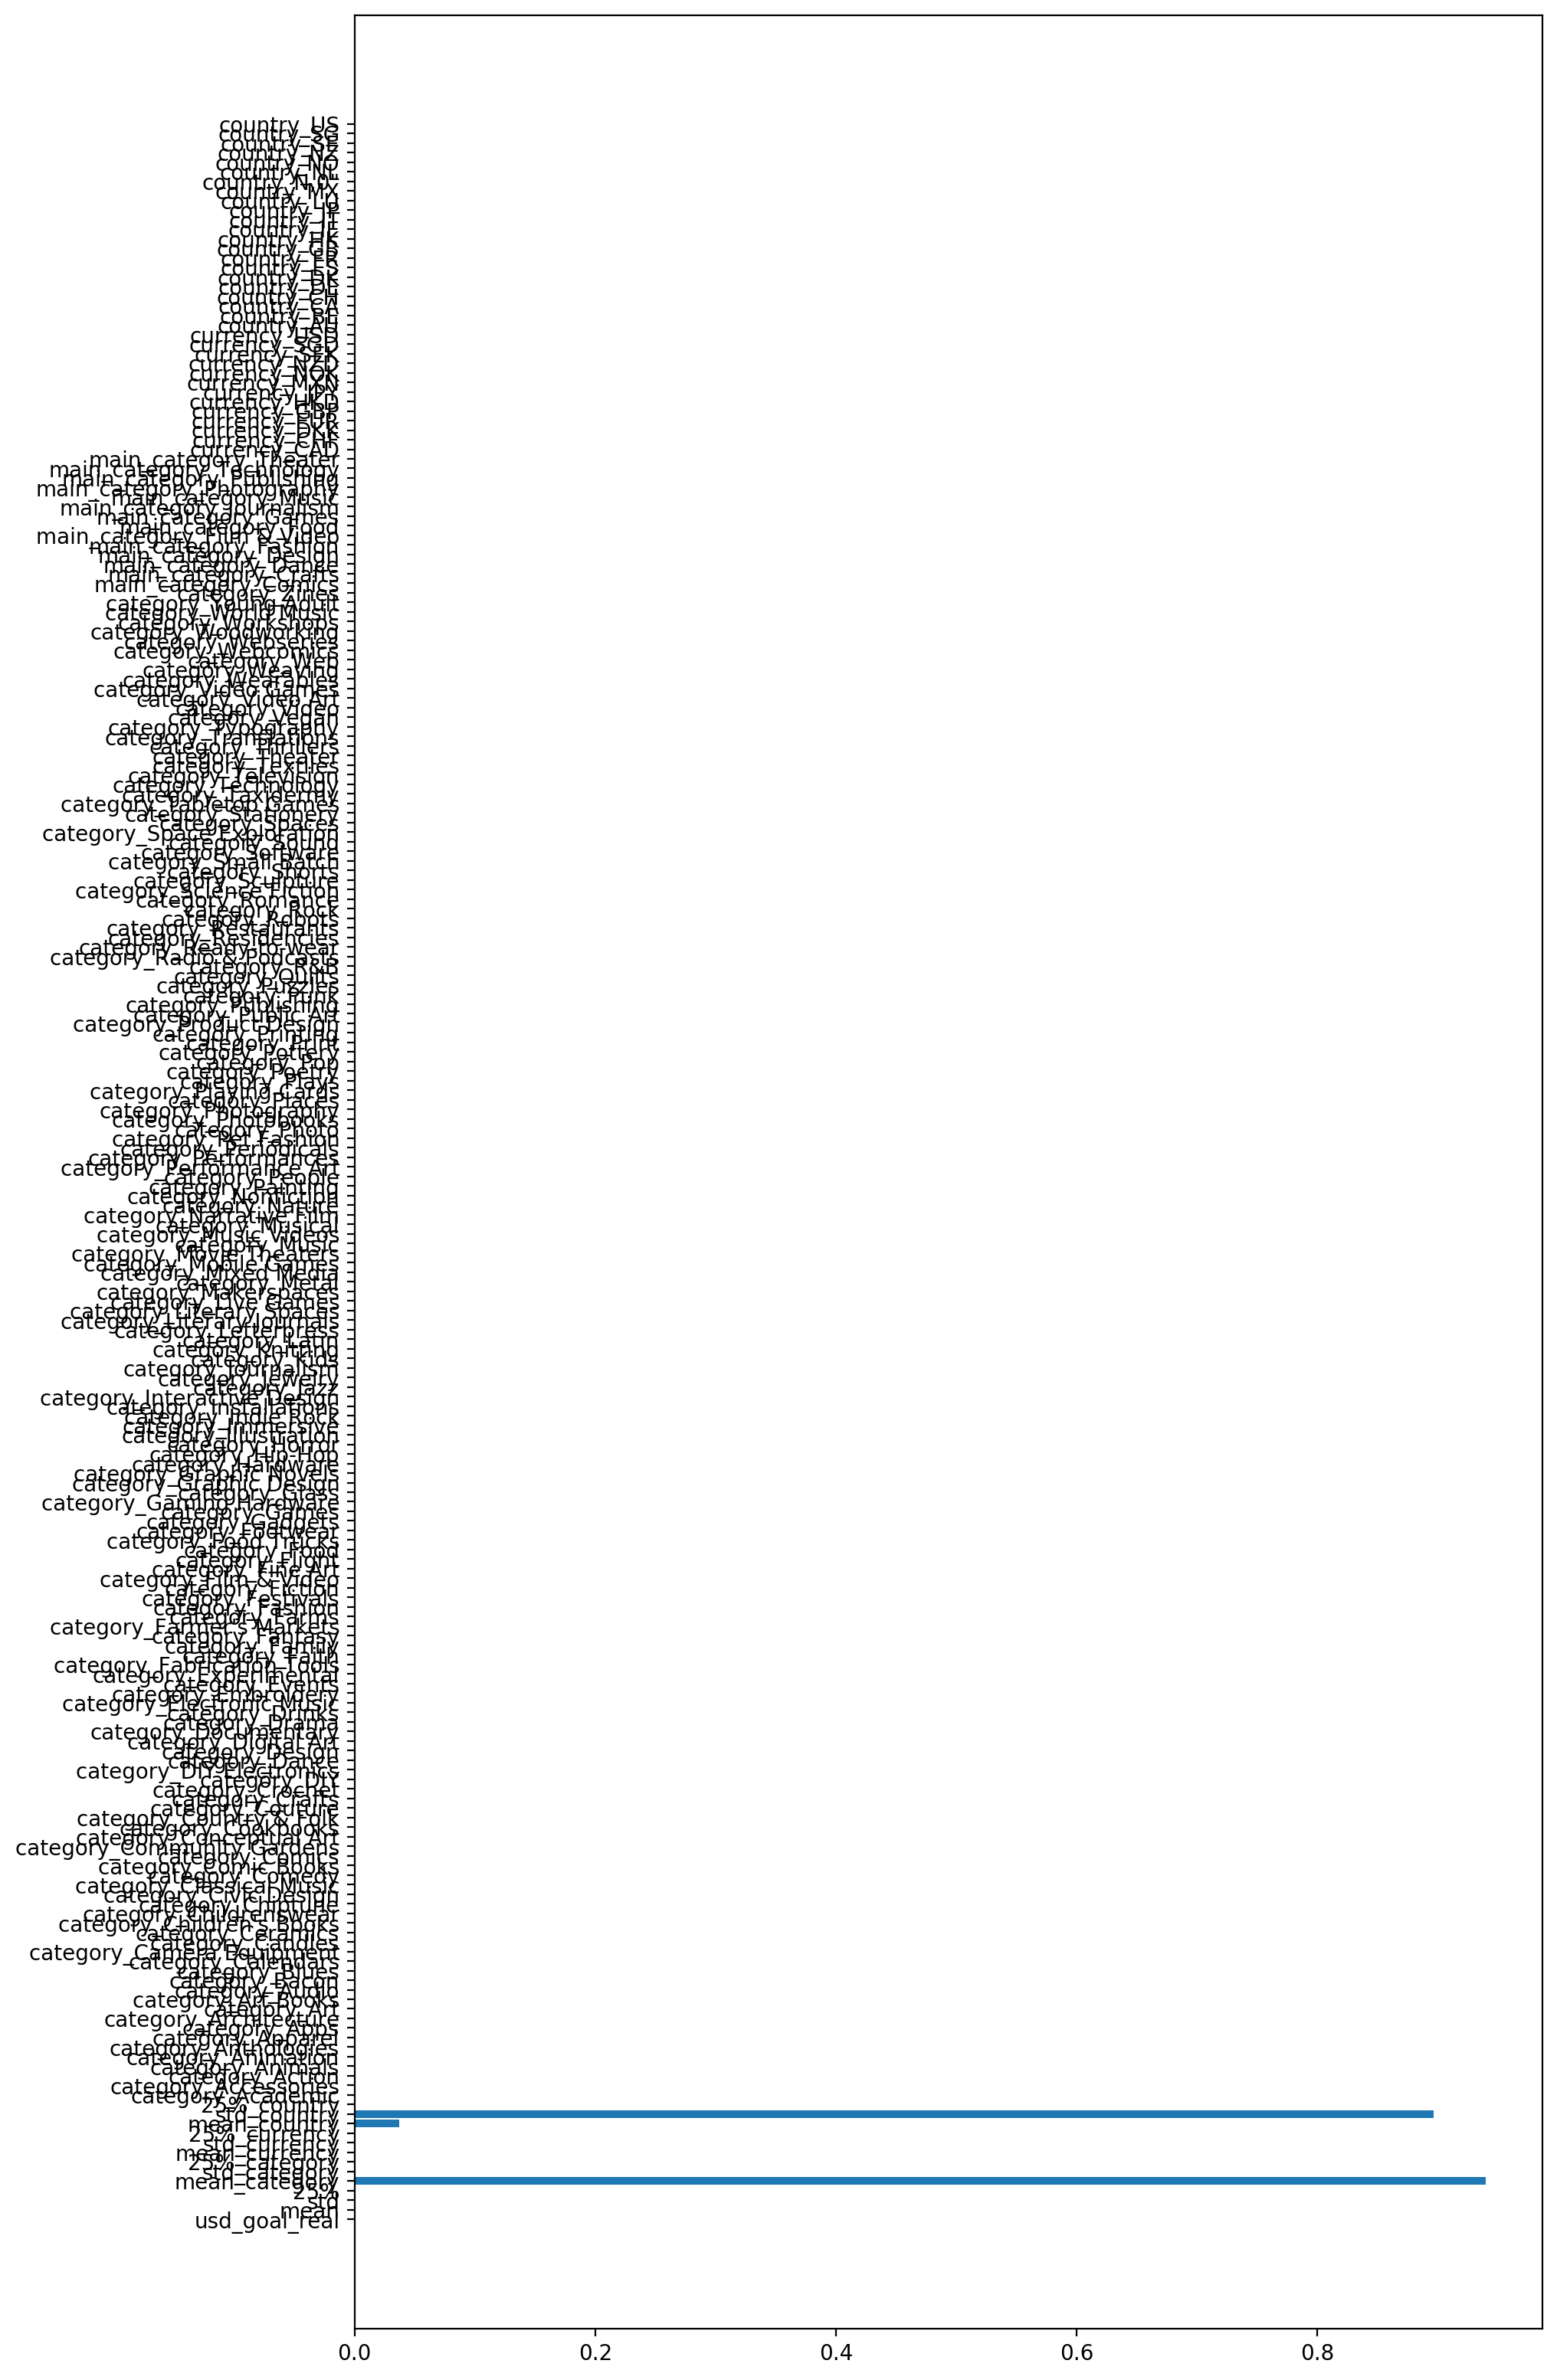

In [19]:
# 係数を棒グラフで表示
plt.figure(figsize=(10,20),dpi=200)
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_X_train.columns.values)
plt.show()

In [20]:
df_X_train.columns[removed_idx]

Index(['usd_goal_real', 'mean', 'std', '25%', 'std_category', '25%_category',
       'mean_currency', 'std_currency', '25%_currency', '25%_country',
       ...
       'country_JP', 'country_LU', 'country_MX', 'country_N,0"', 'country_NL',
       'country_NO', 'country_NZ', 'country_SE', 'country_SG', 'country_US'],
      dtype='object', length=217)

In [21]:
df_X_train = df_X_train.drop(df_X_train.columns[removed_idx], axis=1)
df_X_test = df_X_test.drop(df_X_test.columns[removed_idx], axis=1)


In [22]:
X_train = df_X_train.values
X_test = df_X_test.values

In [23]:
# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

print("学習データに対する誤差")

# MSEを計算
mse = mean_squared_error(y_train, y_pred_train) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_train, y_pred_train) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

# 決定係数R^2を計算
r2 = r2_score(y_train, y_pred_train) 
print("R^2 = %s"%round(r2, 3))

# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)

print("予測データに対する誤差")

# MSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_test, y_pred_test) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

# 決定係数R^2を計算
r2 = r2_score(y_test, y_pred_test) 
print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 2678.862
MAE = 44.348
RMSE = 51.758
R^2 = 0.098
予測データに対する誤差
MSE = 2679.35
MAE = 44.366
RMSE = 51.762
R^2 = 0.095


In [24]:
model = MLPRegressor(hidden_layer_sizes=(100,100,100,100,),random_state=42,early_stopping=True)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("学習データに対する誤差")
# MSEを計算
mse = mean_squared_error(y_train, y_pred_train) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_train, y_pred_train) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

# 決定係数R^2を計算
r2 = r2_score(y_train, y_pred_train) 
print("R^2 = %s"%round(r2, 3))

print("予測データに対する誤差")

# MSEを計算
mse = mean_squared_error(y_test, y_pred_test) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_test, y_pred_test) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

# 決定係数R^2を計算
r2 = r2_score(y_test, y_pred_test) 
print("R^2 = %s"%round(r2, 3))

学習データに対する誤差
MSE = 2677.97
MAE = 43.972
RMSE = 51.749
R^2 = 0.098
予測データに対する誤差
MSE = 2678.681
MAE = 43.997
RMSE = 51.756
R^2 = 0.096


## 特徴選択をした結果

| model            | target | data  | MSE      | MAE    | RMSE   | R^2   |
|------------------|--------|-------|----------|--------|--------|-------|
| LinearRegression | ALL    | train | 2678.862 | 44.348 | 51.758 | 0.098 |
| MLPRegressor     | ALL    | train | 2677.97  | 43.972 | 51.749 | 0.098 |
| LinearRegression | ALL    | test  | 2679.35  | 44.366 | 51.762 | 0.095 |
| MLPRegressor     | ALL    | test  | 2678.681 | 43.997 | 51.756 | 0.096 |

### DAY2の特徴選択をする前

| model            | target | data  | MSE      | MAE  | RMSE | R^2   |
|------------------|--------|-------|----------|------|------|-------|
| LinearRegression | ALL    | train | 2674.984 | 44.3 | 51.7 | 0.099 |
| LinearRegression | ALL    | test  | 2675.519 | 44.3 | 51.7 | 0.097 |

### 考察
特徴選択をする前と後のLinearRegressionを比較すると、ほぼ数値が変わっていないことがわかる。  
そのため、予測結果への影響が少ない説明変数を削除することができた。  